<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Object Detection using Detectron2

**Notes:** 
- This must be run on a GPU

**References**:
- Read the Facebook AI Research team's [blog post](https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/) about Detectron2
- This notebook includes code from the [official Detectron2 tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5)

## Introduction to Detectron2



In [9]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

## Set up

In [10]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Load and prepare images

We will use OpenCV's `cv2.imread()` function to load our images. Since this function loads images as BGR we need to convert our images to RGB so we can display them with the correct colors.

Because it is pre-trained on COCO images, the expected input size for Detectron2 is 416 x 416 x 3. Since our images have different sizes, we have to resize our images to be compatible with the input size of the first layer in the network. In the code below, we resize our images using OpenCV's `cv2.resize()` function.

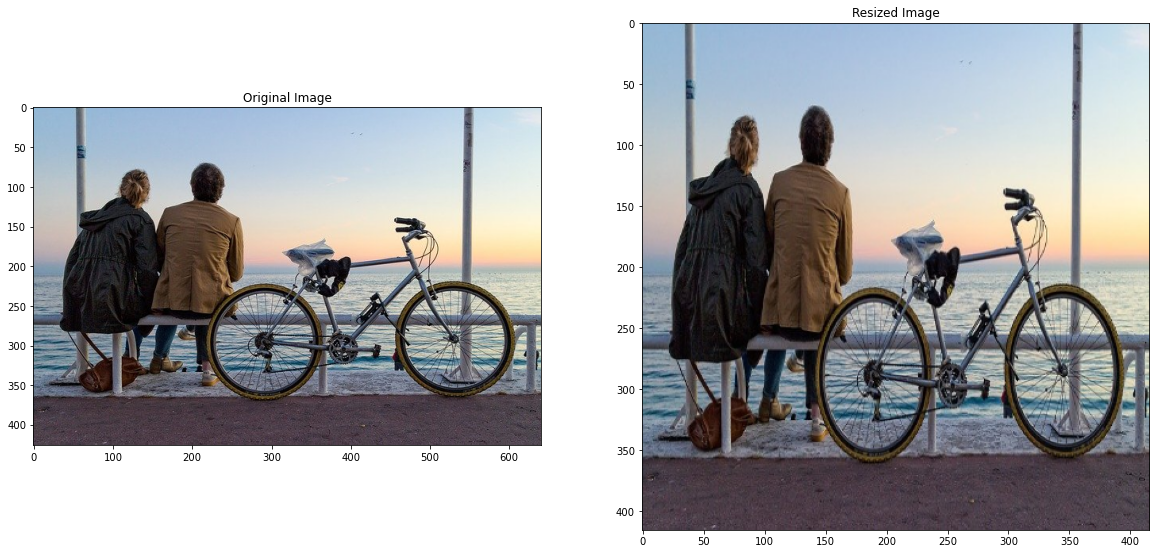

In [12]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [20, 10]

# Load the image
img = cv2.imread('../data/images/bike.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (model.width, model.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

## Detect objects
We can now use the pre-trained Detectron2 model to detect objects in our image.  The model returns a list of bounding boxes identified in the image, with each box containing seven values: the coordinates *(x, y)* of the center of the bounding box, the width *w* and height *h* of the bounding box, the confidence detection level, the object class probability, and the object class id.

### Non-Maximal Suppression (NMS)

The output from the model includes all bounding boxes identified.  Some of them may be low probability, and some of them may be overlapping.  YOLO uses **Non-Maximal Suppression (NMS)** to only keep the best bounding box and eliminate duplicates. NMS includes two steps:
1) The first step is to remove all the predicted bounding boxes that have a detection probability that is less than the selected NMS threshold. This is done by Darknet for us - we just need to provide the desired detection probability threshold.

2) The second step is to eliminate duplicate bounding boxes which refer to the same object.  We do this by calculating the **Intersection over Union (IOU)** value for each pair of boxes and then eliminate one when the IOU value is above a set threshold.  The box we keep from the pair is the one with the higher detection probability.  The below function `boxes_iou()` calculates the IOU value for a pair of bounding boxes, and the function `nms()` performs the second step of the NMS process on all of the bounding boxes identified by the model to remove duplicates.

In [ ]:
# Load and configure the pre-trained model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

outputs = predictor(im)

In [ ]:
# Get outputs from model
outputs = predictor(resized_image)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])